# Лабораторная работа 2
### Выполнил: Алешин А И

Добро пожаловать в лабораторную работу! 
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках. 
Где необходимо, используйте графики для большей наглядности.

In [1]:
# импортируем библиотеки для анализа данных
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# импортируем catboost
import catboost
from catboost import *

In [3]:
df = pd.read_csv('DOTA2_TRAIN_features.csv')
df = df.drop(['match_id'],axis = 1)

In [4]:
df # фичи 

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,2117,22,7,15,1,5,4.0,9,15,0,...,0.133,3,1,7,0,0.405,0,0,0,0
1,3914,22,7,28,177,87,3.0,15,22,5,...,0.000,5,2,14,0,0.352,0,0,1,0
2,100000000,22,0,6,1,42,0.0,0,1,1,...,17.462,0,0,10,0,0.625,0,0,0,0
3,475,22,7,1,3,48,0.0,1,0,0,...,0.000,0,0,3,1,0.500,0,0,0,0
4,581,22,7,1,1,41,0.0,0,0,3,...,0.000,0,0,1,0,0.000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,1584,4,0,12,9,43,4.0,2,5,9,...,8.331,0,0,3,0,0.476,0,0,1,2
27768,925,22,0,2,0,14,3.0,5,2,4,...,14.363,0,0,3,0,0.188,0,0,2,0
27769,2522,22,7,16,12,34,16.0,6,10,6,...,4.566,0,0,0,0,0.077,0,0,0,0
27770,797,22,7,3,0,69,2.0,2,4,4,...,0.000,0,0,6,0,0.375,0,0,1,1


In [5]:
df.loc[df['game_time'] > 1000000,'game_time'] = np.NaN
df.loc[((df['r2_gold'] > 1000000) | (df['r2_gold'] < 0)),'r2_gold'] = np.NaN
df.loc[((df['r3_gold'] > 1000000) | (df['r3_gold'] < 0)),'r3_gold'] = np.NaN
df.loc[((df['r4_gold'] > 1000000) | (df['r4_gold'] < 0)),'r4_gold'] = np.NaN
df.loc[((df['d4_gold'] > 1000000) | (df['d4_gold'] < 0)),'d4_gold'] = np.NaN
# заменим выбросы на наны чтобы потом с помощью близжайших соседей восстановить и наны и выбросы которые стали нанами

In [6]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")

df11 = imputer.fit_transform(df)

E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [7]:
df11 = pd.DataFrame(df11)
df11.columns = df.columns
df = df11
df

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,2117.0,22.0,7.0,15.0,1.0,5.0,4.000000,9.0,15.0,0.0,...,0.133,3.0,1.0,7.0,0.0,0.405,0.0,0.0,0.0,0.0
1,3914.0,22.0,7.0,28.0,177.0,87.0,3.000000,15.0,22.0,5.0,...,0.000,5.0,2.0,14.0,0.0,0.352,0.0,0.0,1.0,0.0
2,1273.0,22.0,0.0,6.0,1.0,42.0,0.000000,0.0,1.0,1.0,...,17.462,0.0,0.0,10.0,0.0,0.625,0.0,0.0,0.0,0.0
3,475.0,22.0,7.0,1.0,3.0,48.0,0.000000,1.0,0.0,0.0,...,0.000,0.0,0.0,3.0,1.0,0.500,0.0,0.0,0.0,0.0
4,581.0,22.0,7.0,1.0,1.0,41.0,0.000000,0.0,0.0,3.0,...,0.000,0.0,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,1584.0,4.0,0.0,12.0,9.0,43.0,4.000000,2.0,5.0,9.0,...,8.331,0.0,0.0,3.0,0.0,0.476,0.0,0.0,1.0,2.0
27768,925.0,22.0,0.0,2.0,0.0,14.0,3.000000,5.0,2.0,4.0,...,14.363,0.0,0.0,3.0,0.0,0.188,0.0,0.0,2.0,0.0
27769,2522.0,22.0,7.0,16.0,12.0,34.0,16.000000,6.0,10.0,6.0,...,4.566,0.0,0.0,0.0,0.0,0.077,0.0,0.0,0.0,0.0
27770,797.0,22.0,7.0,3.0,0.0,69.0,2.000000,2.0,4.0,4.0,...,0.000,0.0,0.0,6.0,0.0,0.375,0.0,0.0,1.0,1.0


Так как в конечном итоге нам не нужны будут все эти признаки потому что мы на генератором новых мы создадим список со всеми признаками которые есть в начальном дата сайте кроме категориальных

In [8]:
dfghg = df.drop(['game_mode','lobby_type','r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'],axis = 1)
vvvvv = dfghg.columns

Мы по командам объединяет основные признаки это изначально дальше мы из r отнимаем d
получаются нормальные распределения по типу рисунка в 24 блокноте чем дальше от 0 тем более  более выраженное признак либо в одну либо в другую сторону. значит уже видно сразу тенденции далее я генерировал признаки от самых хороших то я ао катьусту смотрел лушие признаки и за счет них генерировал новые. Чтобы увеличить скорость обучения как раз таки удалил около 240 первоначальных признаков чтобы лог регрессии было полегче. 

In [9]:
df['radiant_gold'] = df['r1_gold'] + df['r2_gold'] + df['r3_gold'] + df['r4_gold'] + df['r5_gold']
df['radiant_xp'] = df['r1_xp'] + df['r2_xp'] + df['r3_xp'] + df['r4_xp'] + df['r5_xp']
df['radiant_gold_xp_ratio'] = df['radiant_gold']/df['radiant_xp']
df['radiant_vision'] = df['r1_obs_placed'] + df['r2_obs_placed'] + df['r3_obs_placed'] + df['r4_obs_placed'] + df['r5_obs_placed'] + df['r1_sen_placed'] + df['r2_sen_placed'] + df['r3_sen_placed'] + df['r4_sen_placed'] + df['r5_sen_placed']
df['radiant_sen'] = df['r1_sen_placed'] + df['r2_sen_placed'] + df['r3_sen_placed'] + df['r4_sen_placed'] + df['r5_sen_placed']
df['radiant_towers_killed'] = df['r1_towers_killed'] + df['r2_towers_killed'] + df['r3_towers_killed'] + df['r4_towers_killed'] + df['r5_towers_killed']
df['radiant_stun'] = df['r1_stuns'] + df['r2_stuns'] + df['r3_stuns'] + df['r4_stuns'] + df['r5_stuns']

In [10]:
df['dire_gold'] = df['d1_gold'] + df['d2_gold'] + df['d3_gold'] + df['d4_gold'] + df['d5_gold']
df['dire_xp'] = df['d1_xp'] + df['d2_xp'] + df['d3_xp'] + df['d4_xp'] + df['d5_xp']
df['dire_gold_xp_ratio'] = df['dire_gold']/df['dire_xp']
df['dire_vision'] = df['d1_obs_placed'] + df['d2_obs_placed'] + df['d3_obs_placed'] + df['d4_obs_placed'] + df['d5_obs_placed'] + df['d1_sen_placed'] + df['d2_sen_placed'] + df['d3_sen_placed'] + df['d4_sen_placed'] + df['d5_sen_placed']
df['dire_sen'] = df['d1_sen_placed'] + df['d2_sen_placed'] + df['d3_sen_placed'] + df['d4_sen_placed'] + df['d5_sen_placed']
df['dire_towers_killed'] = df['d1_towers_killed'] + df['d2_towers_killed'] + df['d3_towers_killed'] + df['d4_towers_killed'] + df['d5_towers_killed']
df['dire_stun'] = df['d1_stuns'] + df['d2_stuns'] + df['d3_stuns'] + df['d4_stuns'] + df['d5_stuns']

In [11]:
df['var_gold'] = df['radiant_gold'] - df['dire_gold']
df['var_xp'] = df['radiant_xp'] - df['dire_xp']
df['f'] = df['var_xp'] + df['var_gold']
df['fff'] = np.where(df['f']>0,1,0)
df['var_gold_xp_ratio'] = df['radiant_gold_xp_ratio']/df['dire_gold_xp_ratio']
df['var_vision'] = df['radiant_vision'] - df['dire_vision']
df['var_sen'] = df['radiant_sen'] - df['dire_sen']
df['var_towers_killed'] = df['radiant_towers_killed'] - df['dire_towers_killed']
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [12]:
df['wseqw2'] = df['r2_y'] + df['d2_y']
df['wseqw3'] = df['r3_y'] + df['d3_y']
df['wseqw4'] = df['r4_y'] + df['d4_y']
df['wseqw5'] = df['r5_y'] + df['d5_y']
df['wseqw11'] = df['r1_x'] + df['d1_x']
df['wseqw12'] = df['r2_x'] + df['d2_x']
df['wseqw13'] = df['r3_x'] + df['d3_x']
df['wseqw14'] = df['r4_x'] + df['d4_x']
df['wseqw15'] = df['r5_x'] + df['d5_x']
df['wseqw1'] = df['r1_y'] + df['d1_y'] + df['wseqw2'] + df['wseqw3'] + df['wseqw4'] + df['wseqw5'] + df['wseqw11']+ df['wseqw12'] + df['wseqw13'] + df['wseqw14'] + df['wseqw15']

In [13]:
df['gf'] = df['r1_x'] + df['r2_x'] + df['r3_x'] + df['r4_x'] + df['r5_x']
df['gfc'] = df['r1_y'] + df['r2_y'] + df['r3_y'] + df['r4_y'] + df['r5_y']
df['sd'] = df['r1_deaths'] + df['r2_deaths'] + df['r3_deaths'] + df['r4_deaths'] + df['r5_deaths']
df['sd1'] = df['r1_kills'] + df['r2_kills'] + df['r3_kills'] + df['r4_kills'] + df['r5_kills']
df['sd2'] = df['d1_assists'] + df['d2_assists'] + df['d3_assists'] + df['d4_assists'] + df['d5_assists']
df['sd3'] = df['r1_health'] + df['r2_health'] + df['r3_health'] + df['r4_health'] + df['r5_health']
df['sd4'] = df['r1_denies'] + df['r2_denies'] + df['r3_denies'] + df['r4_denies'] + df['r5_denies']
df['sd5'] = df['r1_max_mana'] + df['r2_max_mana'] + df['r3_max_mana'] + df['r4_max_mana'] + df['r5_max_mana']
df['sd6'] = df['r1_level'] + df['r2_level'] + df['r3_level'] + df['r4_level'] + df['r5_level']
df['sd7'] = df['r1_creeps_stacked'] + df['r2_creeps_stacked'] + df['r3_creeps_stacked'] + df['r4_creeps_stacked'] + df['r5_creeps_stacked']
df['sd8'] = df['r1_camps_stacked'] + df['r2_camps_stacked'] + df['r3_camps_stacked'] + df['r4_camps_stacked'] + df['r5_camps_stacked']
df['sd9'] = df['r1_teamfight_participation'] + df['r2_teamfight_participation'] + df['r3_teamfight_participation'] + df['r4_teamfight_participation'] + df['r5_teamfight_participation']
df['sd10'] = df['r1_towers_killed'] + df['r2_towers_killed'] + df['r3_towers_killed'] + df['r4_towers_killed'] + df['r5_towers_killed']
df['sd11'] = df['r1_roshans_killed'] + df['r2_roshans_killed'] + df['r3_roshans_killed'] + df['r4_roshans_killed'] + df['r5_roshans_killed']
df['sd12'] = df['r1_obs_placed'] + df['r2_obs_placed'] + df['r3_obs_placed'] + df['r4_obs_placed'] + df['r5_obs_placed']
df['sd13'] = df['r1_sen_placed'] + df['r2_sen_placed'] + df['r3_sen_placed'] + df['r4_sen_placed'] + df['r5_sen_placed']

In [14]:
df['sdd'] = df['d1_deaths'] + df['d2_deaths'] + df['d3_deaths'] + df['d4_deaths'] + df['d5_deaths']
df['sdd3'] = df['d1_health'] + df['d2_health'] + df['d3_health'] + df['d4_health'] + df['d5_health']
df['sdd4'] = df['d1_denies'] + df['d2_denies'] + df['d3_denies'] + df['d4_denies'] + df['d5_denies']
df['sdd5'] = df['d1_max_mana'] + df['d2_max_mana'] + df['d3_max_mana'] + df['d4_max_mana'] + df['d5_max_mana']
df['sdd6'] = df['d1_level'] + df['d2_level'] + df['d3_level'] + df['d4_level'] + df['d5_level']
df['sdd7'] = df['d1_creeps_stacked'] + df['d2_creeps_stacked'] + df['d3_creeps_stacked'] + df['d4_creeps_stacked'] + df['d5_creeps_stacked']
df['sdd8'] = df['d1_camps_stacked'] + df['d2_camps_stacked'] + df['d3_camps_stacked'] + df['d4_camps_stacked'] + df['d5_camps_stacked']
df['sdd9'] = df['d1_teamfight_participation'] + df['d2_teamfight_participation'] + df['d3_teamfight_participation'] + df['d4_teamfight_participation'] + df['d5_teamfight_participation']
df['sdd10'] = df['d1_towers_killed'] + df['d2_towers_killed'] + df['d3_towers_killed'] + df['d4_towers_killed'] + df['d5_towers_killed']
df['sdd11'] = df['d1_roshans_killed'] + df['d2_roshans_killed'] + df['d3_roshans_killed'] + df['d4_roshans_killed'] + df['d5_roshans_killed']
df['sdd12'] = df['d1_obs_placed'] + df['d2_obs_placed'] + df['d3_obs_placed'] + df['d4_obs_placed'] + df['d5_obs_placed']
df['sdd13'] = df['d1_sen_placed'] + df['d2_sen_placed'] + df['d3_sen_placed'] + df['d4_sen_placed'] + df['d5_sen_placed']

In [15]:
df['ddda'] = (df['sd1'] / df['sd']) - 1 
df['dffaa1'] = df['ddda'] > 0

In [16]:
df['sd14'] = df['r1_max_health'] + df['r2_max_health'] + df['r3_max_health'] + df['r4_max_health'] + df['r5_max_health']
df['sd15'] = df['r1_lh'] + df['r2_lh'] + df['r3_lh'] + df['r4_lh'] + df['r5_lh']
df['sdd14'] = df['d1_max_health'] + df['d2_max_health'] + df['d3_max_health'] + df['d4_max_health'] + df['d5_max_health']
df['sdd15'] = df['d1_lh'] + df['d2_lh'] + df['d3_lh'] + df['d4_lh'] + df['d5_lh']

In [17]:
df['sddd'] = df['sd'] - df['sd1']
df['sddd3'] = df['sd3'] - df['sdd3']
df['sddd9'] = df['sd9'] - df['sdd9']
df['sddd4'] = df['sd4'] - df['sdd4']
df['sddd5'] = df['sd5'] - df['sdd5']
df['sddd6'] = df['sd6'] - df['sdd6']
df['sddd7'] = df['sd7'] - df['sdd7']
df['sddd8'] = df['sd8'] - df['sdd8']
df['sddd10'] = df['sd10'] - df['sdd10']
df['sddd11'] = df['sd11'] - df['sdd11']
df['sddd12'] = df['sd12'] - df['sdd12']
df['sddd13'] = df['sd13'] - df['sdd13']
df['sddd14'] = df['sdd9'] * df['sdd11']
df['sddd15'] = df['sddd9'] + df['sddd11']
df['sddd16'] = df['sddd9'] + df['sddd11'] + df['sddd8'] + df['sddd10']


In [18]:
df['fsddd5'] = df['f'] / df['sdd5']
df['fsddd6'] = df['f'] / df['sdd6']
df['fssddd12'] = df['f'] / df['sd12']

df['fsddd3'] = df['f'] * df['sdd3']
df['fsddd4'] = df['f'] * df['sdd4']
df['fsddd8'] = df['f'] / df['sdd8']
df['fsddd9'] = df['f'] / df['sdd9']
df['fsddd10'] = df['f'] / df['sdd10']
df['fsddd12'] = df['f'] * df['sdd12']
df['fsddd13'] = df['f'] / df['sdd13']
df['fssddd3'] = df['f'] / df['sd3']
df['fssddd4'] = df['f'] / df['sd4']
df['fssddd5'] = df['f'] / df['sd5']

df['fsddd7'] = df['f'] / df['sdd7']
df['fsddd11'] = df['f'] / df['sdd11']
df['fssddd6'] = df['f'] / df['sd6']
df['fssddd7'] = df['f'] / df['sd7']
df['fssddd8'] = df['f'] / df['sd8']
df['fssddd9'] = df['f'] / df['sd9']
df['fssddd10'] = df['f'] / df['sd10']
df['fssddd11'] = df['f'] / df['sd11']
df['fssddd13'] = df['f'] / df['sd13']

df['qwq1'] = df['fsddd6']>400
df['qwq2'] = df['fsddd6']<-400

In [19]:
df['fssddd66'] = df['fssddd6'] / (df['qwq1'] + 1)
df['fssddd67'] = df['fssddd6'] + df['f']*200

In [20]:
df['fssddd16'] = df['f'] / df['sddd14']
df['df1s'] = df['gf'] + df['gfc']
df['sd11'] = df['sd'] + df['sd1']
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [21]:
df['hg']  = df['var_gold']>0
df['hg1']  = df['r1_gold'] + df['r1_gold']
df['hg2']  = df['r4_gold'] + df['r5_gold']
df['hg3']  = df['d1_gold'] + df['d1_gold']
df['hg4']  = df['d4_gold'] + df['d5_gold']

In [22]:
df_target = pd.read_csv('DOTA2_TRAIN_targets.csv')
df['target'] = df_target['radiant_win']

C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='target', ylabel='count'>

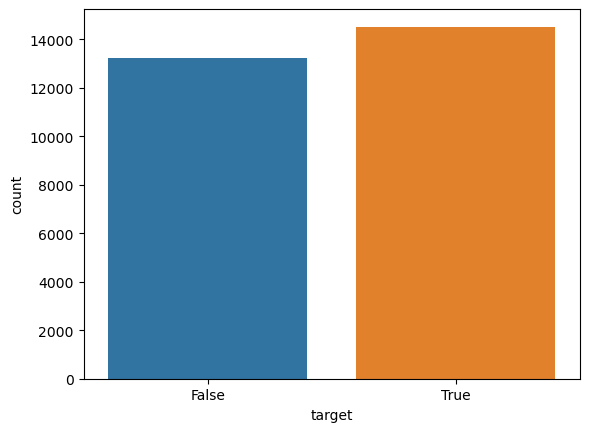

In [23]:
sns.countplot(x = df['target']) # данные распределены равномерно 

C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<AxesSubplot:xlabel='var_gold', ylabel='Count'>

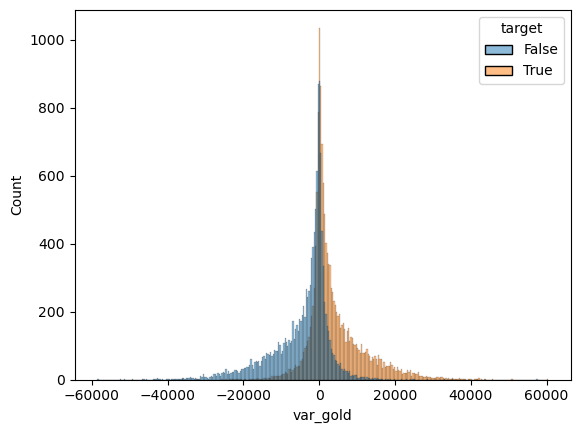

In [24]:
sns.histplot(x = df['var_gold'],hue = df.target)

In [25]:
df['r1_hero_id'] = df['r1_hero_id'].astype('int')
df['r2_hero_id'] = df['r2_hero_id'].astype('int')
df['r3_hero_id'] = df['r3_hero_id'].astype('int')
df['r4_hero_id'] = df['r4_hero_id'].astype('int')
df['r5_hero_id'] = df['r5_hero_id'].astype('int')
df['d1_hero_id'] = df['d1_hero_id'].astype('int')
df['d2_hero_id'] = df['d2_hero_id'].astype('int')
df['d3_hero_id'] = df['d3_hero_id'].astype('int')
df['d4_hero_id'] = df['d4_hero_id'].astype('int')
df['d5_hero_id'] = df['d5_hero_id'].astype('int')
df['game_mode'] = df['game_mode'].astype('int')
df['lobby_type'] = df['lobby_type'].astype('int')

In [26]:
df['r1_hero_id'] = df['r1_hero_id'].astype('category')
df['r2_hero_id'] = df['r2_hero_id'].astype('category')
df['r3_hero_id'] = df['r3_hero_id'].astype('category')
df['r4_hero_id'] = df['r4_hero_id'].astype('category')
df['r5_hero_id'] = df['r5_hero_id'].astype('category')
df['d1_hero_id'] = df['d1_hero_id'].astype('category')
df['d2_hero_id'] = df['d2_hero_id'].astype('category')
df['d3_hero_id'] = df['d3_hero_id'].astype('category')
df['d4_hero_id'] = df['d4_hero_id'].astype('category')
df['d5_hero_id'] = df['d5_hero_id'].astype('category')
df['game_mode'] = df['game_mode'].astype('category')
df['lobby_type'] = df['lobby_type'].astype('category')

In [27]:
df

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,fssddd66,fssddd67,fssddd16,df1s,hg,hg1,hg2,hg3,hg4,target
0,2117.0,22,7,15.0,1.0,5,4.000000,9.0,15.0,0.0,...,-191.048611,-3.668324e+06,-7804.539007,1080.0,False,17994.0,24484.0,29578.0,28544.666667,False
1,3914.0,22,7,28.0,177.0,87,3.000000,15.0,22.0,5.0,...,229.178862,5.638029e+06,0.000000,1514.0,True,42560.0,72454.0,63504.0,41209.000000,True
2,1273.0,22,0,6.0,1.0,42,0.000000,0.0,1.0,1.0,...,-2.868852,-3.500287e+04,0.000000,1260.0,True,15696.0,13494.0,14350.0,12407.000000,True
3,475.0,22,7,1.0,3.0,48,0.000000,1.0,0.0,0.0,...,-147.800000,-7.391478e+05,0.000000,1168.0,False,2810.0,4360.0,5556.0,4361.000000,False
4,581.0,22,7,1.0,1.0,41,0.000000,0.0,0.0,3.0,...,68.354839,4.238684e+05,0.000000,1124.0,True,4896.0,4650.0,4964.0,4027.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,1584.0,4,0,12.0,9.0,43,4.000000,2.0,5.0,9.0,...,80.346154,1.253480e+06,0.000000,1562.0,True,25408.0,26975.0,18032.0,17600.000000,True
27768,925.0,22,0,2.0,0.0,14,3.000000,5.0,2.0,4.0,...,-138.400000,-1.245738e+06,0.000000,1198.0,False,7882.0,11336.0,8484.0,8356.000000,True
27769,2522.0,22,7,16.0,12.0,34,16.000000,6.0,10.0,6.0,...,-75.698113,-1.604876e+06,-3937.193327,1164.0,False,56042.0,35560.0,50550.0,21132.000000,True
27770,797.0,22,7,3.0,0.0,69,2.000000,2.0,4.0,4.0,...,-32.875000,-2.630329e+05,0.000000,1126.0,True,8118.0,5589.0,9592.0,7557.000000,False


In [28]:
df = pd.get_dummies(df)
df

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,...,d5_hero_id_107,d5_hero_id_108,d5_hero_id_109,d5_hero_id_110,d5_hero_id_111,d5_hero_id_112,d5_hero_id_113,d5_hero_id_114,d5_hero_id_119,d5_hero_id_120
0,2117.0,15.0,1.0,4.000000,9.0,15.0,0.0,8997.0,33.0,14849.0,...,False,False,False,False,False,False,False,False,False,False
1,3914.0,28.0,177.0,3.000000,15.0,22.0,5.0,21280.0,73.0,24302.0,...,False,False,False,False,False,False,False,False,False,False
2,1273.0,6.0,1.0,0.000000,0.0,1.0,1.0,7848.0,132.0,7672.0,...,False,False,False,False,False,False,False,False,False,False
3,475.0,1.0,3.0,0.000000,1.0,0.0,0.0,1405.0,12.0,505.0,...,False,False,False,False,False,False,False,False,False,False
4,581.0,1.0,1.0,0.000000,0.0,0.0,3.0,2448.0,34.0,2687.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27767,1584.0,12.0,9.0,4.000000,2.0,5.0,9.0,12704.0,168.0,15742.0,...,False,False,False,False,False,False,False,False,False,False
27768,925.0,2.0,0.0,3.000000,5.0,2.0,4.0,3941.0,22.0,5304.0,...,False,False,False,False,False,False,False,False,False,False
27769,2522.0,16.0,12.0,16.000000,6.0,10.0,6.0,28021.0,407.0,27016.0,...,False,False,False,False,False,False,False,False,False,False
27770,797.0,3.0,0.0,2.000000,2.0,4.0,4.0,4059.0,36.0,3787.0,...,False,False,False,False,False,False,False,False,False,False


In [29]:
df = df.drop(vvvvv,axis = 1)

C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<AxesSubplot:xlabel='fssddd6', ylabel='Count'>

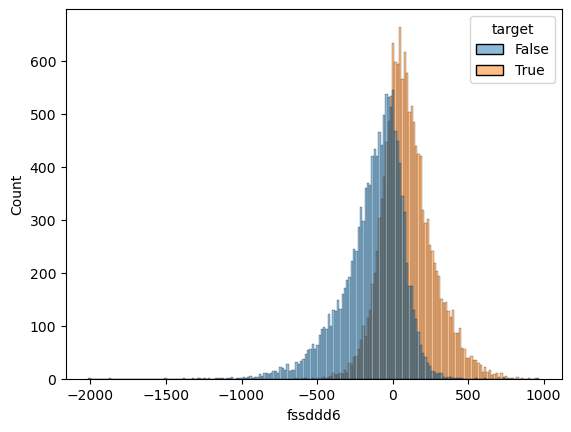

In [30]:
sns.histplot(x = df['fssddd6'],hue = df.target) # лучший признак который получилосб сгенерировать 

In [31]:
y = df.target

In [32]:
X = df.drop(['target'], axis = 1)

### Model & training (Выбор модели и её обучение)

В этом разделе описываете модель и ставите эксперименты по обучению.

Если вы ставили много экспериментов, приведите их в хронологическом порядке чтобы мы увидели эволюцию ваших рассуждений.

#### Эксперимент 1

Градиентный бустинг - это техника, которая комбинирует несколько слабых моделей предсказания, таких как деревья решений, чтобы создать более мощную и точную модель. я поставил маленький шаг и большое число итерация чтобы точность была выше. Это метод машинного обучения, который используется для построения прогностических моделей. Он основан на идее построения ансамбля слабых моделей (например, деревьев решений), которые вместе образуют более сильную модель. Процесс градиентного бустинга начинается с построения первой слабой модели на основе имеющихся данных. Затем, используя градиентный спуск, настраивается вторая модель таким образом, чтобы она исправляла ошибки первой модели. После этого процесс повторяется для каждой следующей модели, при этом каждая новая модель исправляет ошибки предыдущих. Создает ансамбль моделей, каждая из которых учитывает ошибки предыдущих моделей и постепенно улучшает прогнозы. Это позволяет получить более точные и надежные прогнозы, чем при использовании отдельных моделей. CatBoost - это алгоритм машинного обучения, который используется для прогнозирования результатов на основе данных. Он использует технику градиентного бустинга для обучения модели, что позволяет ему делать более точные прогнозы.



надеюсь вы видите график теперь точно видите
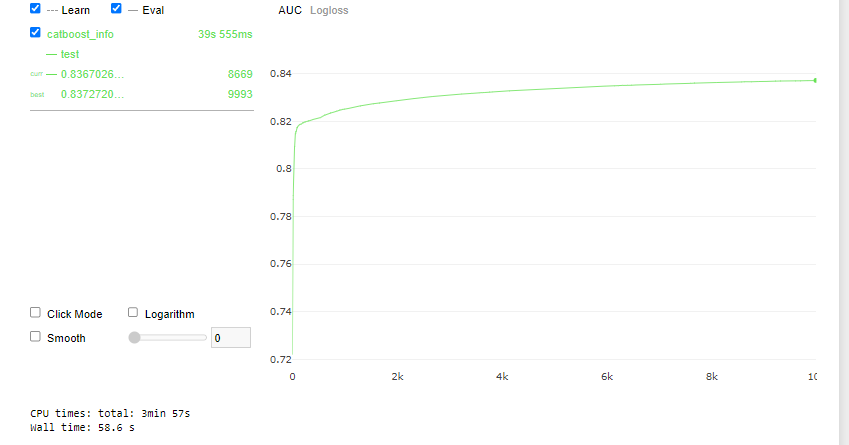

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [34]:
%%time
tunned_model = CatBoostClassifier(
    random_seed=101,
    iterations=10000,
    learning_rate=0.02,
    l2_leaf_reg=7,
    random_strength=5,
    leaf_estimation_method='Newton',
    custom_loss=['AUC'],
    eval_metric='AUC',
    depth=1,
)


tunned_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 3min 54s
Wall time: 1min


In [35]:
tunned_model.get_feature_importance(prettified=True) # значимость признаков 
# из самых значимых изначально наплодил много новых 

,Feature Id,Importances
0,fssddd6,12.701738
1,fsddd6,7.666592
2,fssddd5,7.008453
3,fsddd5,6.237775
4,fssddd66,5.485726
...,...,...
1269,d5_hero_id_107,0.000000
1270,d5_hero_id_110,0.000000
1271,d5_hero_id_111,0.000000
1272,d5_hero_id_112,0.000000


In [36]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_val, y_val)
curve = get_roc_curve(tunned_model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

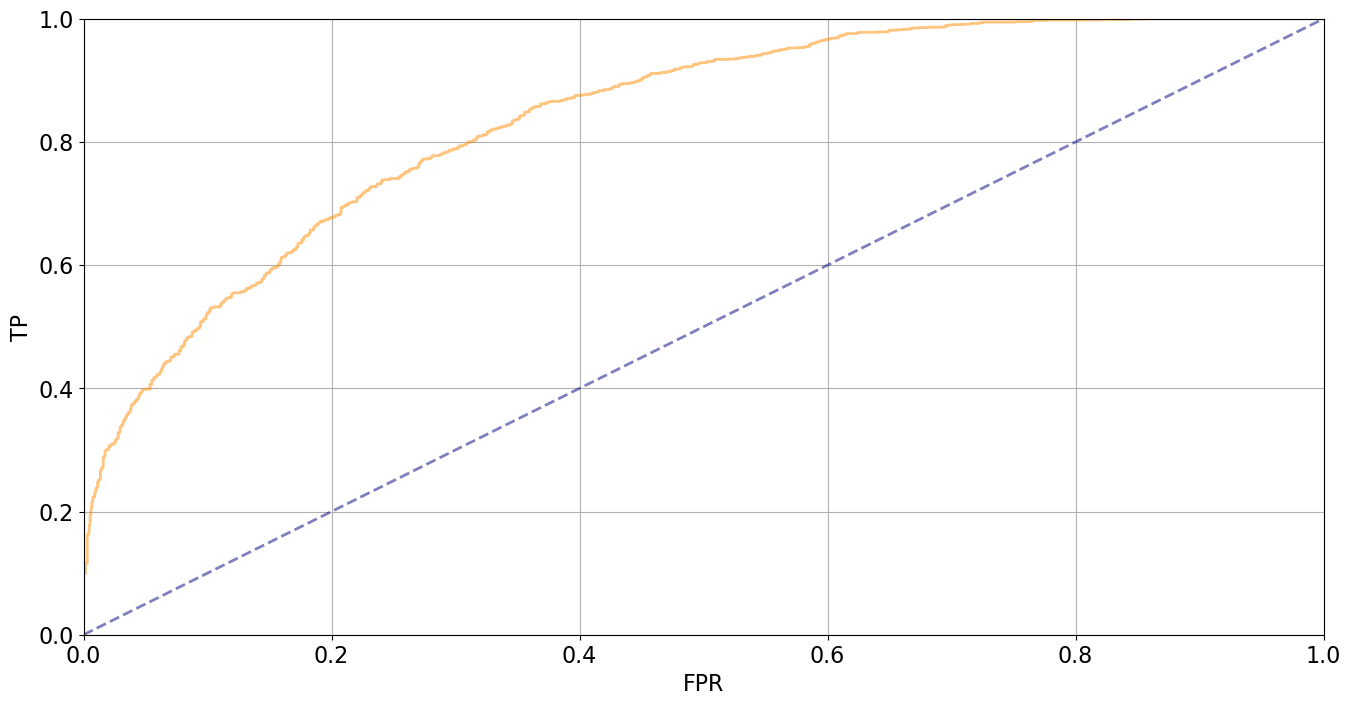

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TP', fontsize=16)
plt.show()

C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<AxesSubplot:ylabel='Count'>

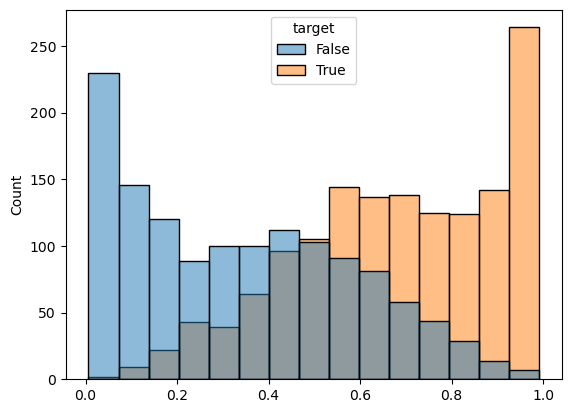

In [38]:
sns.histplot(x = tunned_model.predict_proba(X_val).T[1],hue =y_val)

#### Эксперимент 2

логистическая регрессия как раз таки идет как вспомогательный модуль к катбусту чтобы она хорошо работала данные необходимо стандартизировать. 

In [39]:
from sklearn.model_selection import train_test_split

X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.02, random_state=0)

In [40]:

from sklearn.preprocessing import StandardScaler 
x = StandardScaler()

X_train1 = x.fit_transform(X_train1)
X_val1 = x.transform(X_val1)

E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [41]:
%%time
from sklearn.linear_model import LogisticRegression
Log_reg = LogisticRegression(C = 3)

Log_reg.fit(X_train1, y_train1)
Log_predictions = Log_reg.predict_proba(X_val1)

CPU times: total: 15.2 s
Wall time: 3.26 s


E:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val1,Log_predictions.T[1])

0.826187219073676

C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\allyo\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<AxesSubplot:ylabel='Count'>

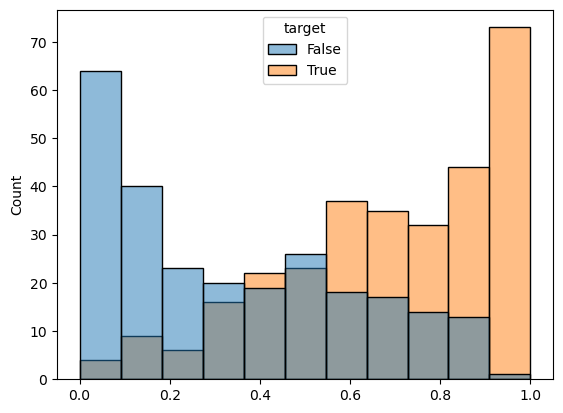

In [43]:
sns.histplot(x = Log_predictions.T[1],hue =y_val1)

в дальнейшем для улучшения результата обЬединю 2 модели в соотношении 60 на 40 где 60 это катбуст и 40 лог регрессия чтобы увеличить обобщающую способность модели и уменьшить вероятность переобучения.


### Evaluation (оценка качества модели)

In [44]:
df = pd.read_csv('DOTA2_TEST_features.csv')
df = df.drop(['match_id'],axis = 1)

In [45]:
df['radiant_gold'] = df['r1_gold'] + df['r2_gold'] + df['r3_gold'] + df['r4_gold'] + df['r5_gold']
df['radiant_xp'] = df['r1_xp'] + df['r2_xp'] + df['r3_xp'] + df['r4_xp'] + df['r5_xp']
df['radiant_gold_xp_ratio'] = df['radiant_gold']/df['radiant_xp']
df['radiant_vision'] = df['r1_obs_placed'] + df['r2_obs_placed'] + df['r3_obs_placed'] + df['r4_obs_placed'] + df['r5_obs_placed'] + df['r1_sen_placed'] + df['r2_sen_placed'] + df['r3_sen_placed'] + df['r4_sen_placed'] + df['r5_sen_placed']
df['radiant_sen'] = df['r1_sen_placed'] + df['r2_sen_placed'] + df['r3_sen_placed'] + df['r4_sen_placed'] + df['r5_sen_placed']
df['radiant_towers_killed'] = df['r1_towers_killed'] + df['r2_towers_killed'] + df['r3_towers_killed'] + df['r4_towers_killed'] + df['r5_towers_killed']
df['radiant_stun'] = df['r1_stuns'] + df['r2_stuns'] + df['r3_stuns'] + df['r4_stuns'] + df['r5_stuns']

In [46]:
df['dire_gold'] = df['d1_gold'] + df['d2_gold'] + df['d3_gold'] + df['d4_gold'] + df['d5_gold']
df['dire_xp'] = df['d1_xp'] + df['d2_xp'] + df['d3_xp'] + df['d4_xp'] + df['d5_xp']
df['dire_gold_xp_ratio'] = df['dire_gold']/df['dire_xp']
df['dire_vision'] = df['d1_obs_placed'] + df['d2_obs_placed'] + df['d3_obs_placed'] + df['d4_obs_placed'] + df['d5_obs_placed'] + df['d1_sen_placed'] + df['d2_sen_placed'] + df['d3_sen_placed'] + df['d4_sen_placed'] + df['d5_sen_placed']
df['dire_sen'] = df['d1_sen_placed'] + df['d2_sen_placed'] + df['d3_sen_placed'] + df['d4_sen_placed'] + df['d5_sen_placed']
df['dire_towers_killed'] = df['d1_towers_killed'] + df['d2_towers_killed'] + df['d3_towers_killed'] + df['d4_towers_killed'] + df['d5_towers_killed']
df['dire_stun'] = df['d1_stuns'] + df['d2_stuns'] + df['d3_stuns'] + df['d4_stuns'] + df['d5_stuns']

In [47]:
df['var_gold'] = df['radiant_gold'] - df['dire_gold']
df['var_xp'] = df['radiant_xp'] - df['dire_xp']
df['f'] = df['var_xp'] + df['var_gold']
df['fff'] = np.where(df['f']>0,1,0)
df['var_gold_xp_ratio'] = df['radiant_gold_xp_ratio']/df['dire_gold_xp_ratio']
df['var_vision'] = df['radiant_vision'] - df['dire_vision']
df['var_sen'] = df['radiant_sen'] - df['dire_sen']
df['var_towers_killed'] = df['radiant_towers_killed'] - df['dire_towers_killed']
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [48]:
df['wseqw2'] = df['r2_y'] + df['d2_y']
df['wseqw3'] = df['r3_y'] + df['d3_y']
df['wseqw4'] = df['r4_y'] + df['d4_y']
df['wseqw5'] = df['r5_y'] + df['d5_y']
df['wseqw11'] = df['r1_x'] + df['d1_x']
df['wseqw12'] = df['r2_x'] + df['d2_x']
df['wseqw13'] = df['r3_x'] + df['d3_x']
df['wseqw14'] = df['r4_x'] + df['d4_x']
df['wseqw15'] = df['r5_x'] + df['d5_x']
df['wseqw1'] = df['r1_y'] + df['d1_y'] + df['wseqw2'] + df['wseqw3'] + df['wseqw4'] + df['wseqw5'] + df['wseqw11']+ df['wseqw12'] + df['wseqw13'] + df['wseqw14'] + df['wseqw15']

In [49]:
df['gf'] = df['r1_x'] + df['r2_x'] + df['r3_x'] + df['r4_x'] + df['r5_x']
df['gfc'] = df['r1_y'] + df['r2_y'] + df['r3_y'] + df['r4_y'] + df['r5_y']
df['sd'] = df['r1_deaths'] + df['r2_deaths'] + df['r3_deaths'] + df['r4_deaths'] + df['r5_deaths']
df['sd1'] = df['r1_kills'] + df['r2_kills'] + df['r3_kills'] + df['r4_kills'] + df['r5_kills']
df['sd2'] = df['d1_assists'] + df['d2_assists'] + df['d3_assists'] + df['d4_assists'] + df['d5_assists']
df['sd3'] = df['r1_health'] + df['r2_health'] + df['r3_health'] + df['r4_health'] + df['r5_health']
df['sd4'] = df['r1_denies'] + df['r2_denies'] + df['r3_denies'] + df['r4_denies'] + df['r5_denies']
df['sd5'] = df['r1_max_mana'] + df['r2_max_mana'] + df['r3_max_mana'] + df['r4_max_mana'] + df['r5_max_mana']
df['sd6'] = df['r1_level'] + df['r2_level'] + df['r3_level'] + df['r4_level'] + df['r5_level']
df['sd7'] = df['r1_creeps_stacked'] + df['r2_creeps_stacked'] + df['r3_creeps_stacked'] + df['r4_creeps_stacked'] + df['r5_creeps_stacked']
df['sd8'] = df['r1_camps_stacked'] + df['r2_camps_stacked'] + df['r3_camps_stacked'] + df['r4_camps_stacked'] + df['r5_camps_stacked']
df['sd9'] = df['r1_teamfight_participation'] + df['r2_teamfight_participation'] + df['r3_teamfight_participation'] + df['r4_teamfight_participation'] + df['r5_teamfight_participation']
df['sd10'] = df['r1_towers_killed'] + df['r2_towers_killed'] + df['r3_towers_killed'] + df['r4_towers_killed'] + df['r5_towers_killed']
df['sd11'] = df['r1_roshans_killed'] + df['r2_roshans_killed'] + df['r3_roshans_killed'] + df['r4_roshans_killed'] + df['r5_roshans_killed']
df['sd12'] = df['r1_obs_placed'] + df['r2_obs_placed'] + df['r3_obs_placed'] + df['r4_obs_placed'] + df['r5_obs_placed']
df['sd13'] = df['r1_sen_placed'] + df['r2_sen_placed'] + df['r3_sen_placed'] + df['r4_sen_placed'] + df['r5_sen_placed']

In [50]:
df['sdd'] = df['d1_deaths'] + df['d2_deaths'] + df['d3_deaths'] + df['d4_deaths'] + df['d5_deaths']
df['sdd3'] = df['d1_health'] + df['d2_health'] + df['d3_health'] + df['d4_health'] + df['d5_health']
df['sdd4'] = df['d1_denies'] + df['d2_denies'] + df['d3_denies'] + df['d4_denies'] + df['d5_denies']
df['sdd5'] = df['d1_max_mana'] + df['d2_max_mana'] + df['d3_max_mana'] + df['d4_max_mana'] + df['d5_max_mana']
df['sdd6'] = df['d1_level'] + df['d2_level'] + df['d3_level'] + df['d4_level'] + df['d5_level']
df['sdd7'] = df['d1_creeps_stacked'] + df['d2_creeps_stacked'] + df['d3_creeps_stacked'] + df['d4_creeps_stacked'] + df['d5_creeps_stacked']
df['sdd8'] = df['d1_camps_stacked'] + df['d2_camps_stacked'] + df['d3_camps_stacked'] + df['d4_camps_stacked'] + df['d5_camps_stacked']
df['sdd9'] = df['d1_teamfight_participation'] + df['d2_teamfight_participation'] + df['d3_teamfight_participation'] + df['d4_teamfight_participation'] + df['d5_teamfight_participation']
df['sdd10'] = df['d1_towers_killed'] + df['d2_towers_killed'] + df['d3_towers_killed'] + df['d4_towers_killed'] + df['d5_towers_killed']
df['sdd11'] = df['d1_roshans_killed'] + df['d2_roshans_killed'] + df['d3_roshans_killed'] + df['d4_roshans_killed'] + df['d5_roshans_killed']
df['sdd12'] = df['d1_obs_placed'] + df['d2_obs_placed'] + df['d3_obs_placed'] + df['d4_obs_placed'] + df['d5_obs_placed']
df['sdd13'] = df['d1_sen_placed'] + df['d2_sen_placed'] + df['d3_sen_placed'] + df['d4_sen_placed'] + df['d5_sen_placed']

In [51]:
df['ddda'] = (df['sd1'] / df['sd']) - 1 
df['dffaa1'] = df['ddda'] > 0

In [52]:
df['sd14'] = df['r1_max_health'] + df['r2_max_health'] + df['r3_max_health'] + df['r4_max_health'] + df['r5_max_health']
df['sd15'] = df['r1_lh'] + df['r2_lh'] + df['r3_lh'] + df['r4_lh'] + df['r5_lh']
df['sdd14'] = df['d1_max_health'] + df['d2_max_health'] + df['d3_max_health'] + df['d4_max_health'] + df['d5_max_health']
df['sdd15'] = df['d1_lh'] + df['d2_lh'] + df['d3_lh'] + df['d4_lh'] + df['d5_lh']

In [53]:
df['sddd'] = df['sd'] - df['sd1']
df['sddd3'] = df['sd3'] - df['sdd3']
df['sddd9'] = df['sd9'] - df['sdd9']
df['sddd4'] = df['sd4'] - df['sdd4']
df['sddd5'] = df['sd5'] - df['sdd5']
df['sddd6'] = df['sd6'] - df['sdd6']
df['sddd7'] = df['sd7'] - df['sdd7']
df['sddd8'] = df['sd8'] - df['sdd8']
df['sddd10'] = df['sd10'] - df['sdd10']
df['sddd11'] = df['sd11'] - df['sdd11']
df['sddd12'] = df['sd12'] - df['sdd12']
df['sddd13'] = df['sd13'] - df['sdd13']
df['sddd14'] = df['sdd9'] * df['sdd11']
df['sddd15'] = df['sddd9'] + df['sddd11']
df['sddd16'] = df['sddd9'] + df['sddd11'] + df['sddd8'] + df['sddd10']

In [54]:
df['fsddd5'] = df['f'] / df['sdd5']
df['fsddd6'] = df['f'] / df['sdd6']
df['fssddd12'] = df['f'] / df['sd12']

df['fsddd3'] = df['f'] * df['sdd3']
df['fsddd4'] = df['f'] * df['sdd4']
df['fsddd8'] = df['f'] / df['sdd8']
df['fsddd9'] = df['f'] / df['sdd9']
df['fsddd10'] = df['f'] / df['sdd10']
df['fsddd12'] = df['f'] * df['sdd12']
df['fsddd13'] = df['f'] / df['sdd13']
df['fssddd3'] = df['f'] / df['sd3']
df['fssddd4'] = df['f'] / df['sd4']
df['fssddd5'] = df['f'] / df['sd5']

df['fsddd7'] = df['f'] / df['sdd7']
df['fsddd11'] = df['f'] / df['sdd11']
df['fssddd6'] = df['f'] / df['sd6']
df['fssddd7'] = df['f'] / df['sd7']
df['fssddd8'] = df['f'] / df['sd8']
df['fssddd9'] = df['f'] / df['sd9']
df['fssddd10'] = df['f'] / df['sd10']
df['fssddd11'] = df['f'] / df['sd11']
df['fssddd13'] = df['f'] / df['sd13']

df['qwq1'] = df['fsddd6']>400
df['qwq2'] = df['fsddd6']<-400

In [55]:
df['fssddd66'] = df['fssddd6'] / (df['qwq1'] + 1)
df['fssddd67'] = df['fssddd6'] + df['f']*200

In [56]:
df['fssddd16'] = df['f'] / df['sddd14']
df['df1s'] = df['gf'] + df['gfc']
df['sd11'] = df['sd'] + df['sd1']
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [57]:
df['hg']  = df['var_gold']>0
df['hg1']  = df['r1_gold'] + df['r1_gold']
df['hg2']  = df['r4_gold'] + df['r5_gold']
df['hg3']  = df['d1_gold'] + df['d1_gold']
df['hg4']  = df['d4_gold'] + df['d5_gold']

In [58]:
df['r1_hero_id'] = df['r1_hero_id'].astype('int')
df['r2_hero_id'] = df['r2_hero_id'].astype('int')
df['r3_hero_id'] = df['r3_hero_id'].astype('int')
df['r4_hero_id'] = df['r4_hero_id'].astype('int')
df['r5_hero_id'] = df['r5_hero_id'].astype('int')
df['d1_hero_id'] = df['d1_hero_id'].astype('int')
df['d2_hero_id'] = df['d2_hero_id'].astype('int')
df['d3_hero_id'] = df['d3_hero_id'].astype('int')
df['d4_hero_id'] = df['d4_hero_id'].astype('int')
df['d5_hero_id'] = df['d5_hero_id'].astype('int')
df['game_mode'] = df['game_mode'].astype('int')
df['lobby_type'] = df['lobby_type'].astype('int')

In [59]:
df['r1_hero_id'] = df['r1_hero_id'].astype('category')
df['r2_hero_id'] = df['r2_hero_id'].astype('category')
df['r3_hero_id'] = df['r3_hero_id'].astype('category')
df['r4_hero_id'] = df['r4_hero_id'].astype('category')
df['r5_hero_id'] = df['r5_hero_id'].astype('category')
df['d1_hero_id'] = df['d1_hero_id'].astype('category')
df['d2_hero_id'] = df['d2_hero_id'].astype('category')
df['d3_hero_id'] = df['d3_hero_id'].astype('category')
df['d4_hero_id'] = df['d4_hero_id'].astype('category')
df['d5_hero_id'] = df['d5_hero_id'].astype('category')
df['game_mode'] = df['game_mode'].astype('category')
df['lobby_type'] = df['lobby_type'].astype('category')

In [60]:
df

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,qwq2,fssddd66,fssddd67,fssddd16,df1s,hg,hg1,hg2,hg3,hg4
0,542,23,0,6,0,95,1,2,3,0,...,False,25.698113,2.724257e+05,0.0,1134,False,9592,8512,10388,11912
1,843,22,7,3,18,2,0,1,1,3,...,False,-369.388889,-2.659969e+06,0.0,1116,False,6036,6943,5828,7519
2,491,22,0,1,4,18,0,0,1,0,...,False,76.321429,4.274763e+05,0.0,1230,True,2514,4216,3028,4240
3,1167,22,7,4,0,41,4,0,4,14,...,False,207.741935,5.152415e+06,0.0,1302,True,20308,15976,9692,7945
4,1032,22,7,5,0,84,2,2,4,9,...,False,310.940000,3.109711e+06,0.0,1356,True,8516,11072,8894,7559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11898,1793,22,0,10,4,27,5,8,5,6,...,True,-645.434211,-9.811245e+06,0.0,1106,False,16652,18671,18482,27081
11899,413,22,7,1,0,44,0,0,2,13,...,False,29.545455,1.300295e+05,0.0,1252,True,5288,3499,2420,2622
11900,153,22,7,0,2,21,0,0,0,0,...,False,65.250000,1.566652e+05,0.0,1222,True,1262,1298,1122,910
11901,1457,22,7,10,3,8,2,10,8,7,...,False,83.000000,1.261683e+06,0.0,1342,True,15028,17752,14748,19831


In [61]:
df = pd.get_dummies(df)
df

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,...,d5_hero_id_107,d5_hero_id_108,d5_hero_id_109,d5_hero_id_110,d5_hero_id_111,d5_hero_id_112,d5_hero_id_113,d5_hero_id_114,d5_hero_id_119,d5_hero_id_120
0,542,6,0,1,2,3,0,4796,23,4989,...,False,False,False,False,False,False,False,False,False,False
1,843,3,18,0,1,1,3,3018,38,4286,...,False,False,False,False,False,False,False,False,False,False
2,491,1,4,0,0,1,0,1257,2,2475,...,False,False,False,False,False,False,False,False,False,False
3,1167,4,0,4,0,4,14,10154,155,9806,...,False,False,False,False,False,False,False,False,False,False
4,1032,5,0,2,2,4,9,4258,13,4834,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11898,1793,10,4,5,8,5,6,8326,35,7288,...,False,False,False,False,False,False,False,False,False,False
11899,413,1,0,0,0,2,13,2644,43,2167,...,False,False,False,False,False,False,False,False,False,False
11900,153,0,2,0,0,0,0,631,6,736,...,False,False,False,False,False,False,False,False,False,False
11901,1457,10,3,2,10,8,7,7514,97,7189,...,False,False,False,False,False,False,False,False,False,False


In [62]:
df = df.drop(vvvvv,axis = 1)

In [63]:
df11 = x.transform(df)
fdf1 = tunned_model.predict_proba(df)
Log_predictions = Log_reg.predict_proba(df11)

E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [64]:
df_pred = (fdf1.T[1]*1.2+Log_predictions.T[1]*0.8)/2
df = pd.read_csv('sample_submission.csv')
df['radiant_win'] = df_pred
df.to_csv('sub17.csv',index=False)

### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы. 
Что получилось / не получилось и почему?

С предметной областью соревнования был незнаком поэтому первые несколько недель пришлось разбираться девушка когда увидела что я смотрю видосфы по доте хотела меня броситься пришлось сказать что это все ради науки и хороших результатов. Теперь я холостяк 
Получилось катбуст ручками потыкать логистическую регрессию эксперимента,то есть два лучших экспиремента но они очень неудачно, то есть на ближайших соседей скор был равен 0.815. зачем такую штуку вставлять в лабу так как есть в принципе 2 хороших эксперимента бустинг хорошо работу за счет того что было достаточно много релевантных данных которые удалось получить благодаря анализу логистическая регрессия хорошо работало благодаря корреляции в районе 0.52 и того тому что мы стандартизировали выборку. 